<a href="https://colab.research.google.com/github/littlehousezh/mml2_image_matching/blob/main/MML2_Ensemble_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling Machine Learning 2 Project - Image Matching Challange


### Context
- Data Process
- Package Loading
- Ensemble Model
- Plot Result

# ***Ensemble of the following works***
- SuperGlue
    https://www.kaggle.com/code/losveria/superglue-baseline/notebook
- LoFTR
    https://www.kaggle.com/code/cbeaud/imc-2022-kornia-score-0-725/notebook
- DKM
    https://www.kaggle.com/code/radac98/public-baseline-dkm-0-667


In [ ]:
dry_run = False
! pip install numpy opencv-python torch matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!fusermount -u drive
!google-drive-ocamlfuse drive
# import dataset from kaggle
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

!pip install kaggle
from google.colab import files
files.upload()


!mkdir -p ~/.kaggle 

!cp kaggle.json ~/.kaggle/ 

!chmod 600 ~/.kaggle/kaggle.json 


! kaggle competitions download -c image-matching-challenge-2022

! unzip image-matching-challenge-2022.zip -d image-matching-challenge-2022

fusermount: failed to unmount /content/drive: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found
Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/42572558_3847795752.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/43210627_10009473243.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/43583354_7506898338.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/43641758_9015255137.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/43728242_3176119914.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/43847879_5656257946.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/44446238_9117834424.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/44573130_5715131949.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/images/44579495_1325305773.jpg  
  inflating: image-matching-challenge-2022/train/buckingham_palace/image

# *Import dependencies and install Libs*

In [ ]:
# import required packages
import logging
import time
import os
import numpy as np
import cv2
import csv
from glob import glob
import torch
import matplotlib.pyplot as plt
import gc
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/
# the following dependencies are for superglue
import random
from collections import namedtuple
import sys
sys.path.append("/content/drive/MyDrive/super-glue-pretrained-network")


from models.matching import Matching
from models.utils import frame2tensor

# the following dependencies are for loftr
#!pip install kornia
!pip install git+https://github.com/kornia/kornia

#!pip install kornia_moons
!pip install /content/drive/MyDrive/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install /content/drive/MyDrive/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl
import kornia
from kornia_moons.feature import *
import kornia as K
import kornia.feature as KF

Mounted at /content/drive
/content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-oq_m0nms
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-oq_m0nms
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for kornia: filename=kornia-0.6.8-py2.py3-none-any.whl size=565750 sha256=3d0dc49fc270ab1967e3177e274e7233cf7e7d94d6fd71ee525fb7b1bbd4fca1
  Stored in directory: /tmp/pip-ephem-wheel-cache-1uomfil_/wheels/02/f4/b2/476cc71690e79d9d7a3fcdb1b05f7c7a7c7791bcedd4072d3b
Successfully built kornia
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./MyDrive/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
  Attempting uninstall: kornia
    Found existing i

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# the following dependencies are for DKM
from PIL import Image
sys.path.append('/content/drive/MyDrive/dkm-dependecies/DKM/')
!mkdir -p pretrained/checkpoints
!cp /content/drive/MyDrive/dkm-dependecies/pretrained/dkm.pth pretrained/checkpoints/dkm_base_v11.pth
!pip install -f /content/drive/MyDrive/dkm-dependecies/wheels --no-index einops
!cp -r /content/drive/MyDrive/dkm-dependecies/DKM/ /kaggle/working/DKM/
!cd /kaggle/working/DKM/; pip install -f /content/drive/MyDrive/dkm-dependecies/wheels -e . 
torch.hub.set_dir('/kaggle/working/pretrained/')
from dkm import dkm_base
#dismiss error below, it will not influence the final results, we will not use setup file in the following

mkdir: cannot create directory ‘pretrained’: Operation not supported
cp: cannot create regular file 'pretrained/checkpoints/dkm_base_v11.pth': No such file or directory
Looking in links: /content/drive/MyDrive/dkm-dependecies/wheels
Processing ./MyDrive/dkm-dependecies/wheels/einops-0.4.1-py3-none-any.whl
cp: cannot create directory '/kaggle/working/DKM/': No such file or directory
/bin/bash: line 0: cd: /kaggle/working/DKM/: No such file or directory
ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: /content/drive


# *Settings*

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
src = '../image-matching-challenge-2022/'

## *Utils*

In [ ]:
test_samples = []
with open(f'{src}/test.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        test_samples += [row]


def FlattenMatrix(M, num_digits=8):
    '''Convenience function to write CSV files.'''
    return ' '.join([f'{v:.{num_digits}e}' for v in M.flatten()])


def resize_img_loftr(img, max_len, enlarge_scale, variant_scale, device):
    if max_len == -1:
        scale = 1
    else:
        scale = max(max_len, max(img.shape[0], img.shape[1]) * enlarge_scale) / max(img.shape[0], img.shape[1])
    w = int(round(img.shape[1] * scale) / 8) * 8
    h = int(round(img.shape[0] * scale) / 8) * 8
    
    isResized = False
    if w >= h:
        if int(h * variant_scale) <= w:
            isResized = True
            h = int(h * variant_scale / 8) * 8
    else:
        if int(w * variant_scale) <= h:
            isResized = True
            w = int(w * variant_scale / 8) * 8
    img_resize = cv2.resize(img, (w, h)) 
    img_resize = K.image_to_tensor(img_resize, False).float() / 255.
    
    return img_resize.to(device), (w / img.shape[1], h / img.shape[0]), isResized


def resize_img_superglue(img, max_len, enlarge_scale, variant_scale):
    if max_len == -1:
        scale = 1
    else:
        scale = max(max_len, max(img.shape[0], img.shape[1]) * enlarge_scale) / max(img.shape[0], img.shape[1])
    w = int(round(img.shape[1] * scale))
    h = int(round(img.shape[0] * scale))
    
    isResized = False
    if w >= h:
        if int(h * variant_scale) <= w:
            isResized = True
            h = int(h * variant_scale) 
    else:
        if int(w * variant_scale) <= h:
            isResized = True
            w = int(w * variant_scale)
    img_resize = cv2.resize(img, (w, h)) 
    return img_resize, (w / img.shape[1], h / img.shape[0]), isResized

# *Matchers*

In [ ]:
# ===========================
#          SuperGlue
# ===========================
resize = [-1, ]
resize_float = True
config = {
    "superpoint": {
        "nms_radius": 4, 
        "keypoint_threshold": 0.005,
        "max_keypoints": 2048
    },
    "superglue": {
        "weights": "outdoor",
        "sinkhorn_iterations": 10,
        "match_threshold": 0.2,
    }
}
matching_superglue = Matching(config).eval().to(device)

# ===========================
#          LoFTR
# ===========================
matcher_loftr = KF.LoFTR(pretrained=None)
matcher_loftr.load_state_dict(torch.load("/content/drive/MyDrive/kornia-loftr/loftr_outdoor.ckpt")['state_dict'])
matcher_loftr = matcher_loftr.to(device).eval()

# ===========================
#          DKM
# ===========================
model = dkm_base(pretrained=True, version="v11")

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/Parskatt/storage/releases/download/dkm/dkm_base_v11.pth" to /kaggle/working/pretrained/checkpoints/dkm_base_v11.pth


  0%|          | 0.00/236M [00:00<?, ?B/s]

# Ensemble model - DKM, LoFTR, SuperGlue

In [ ]:

F_dict = {}

scales_lens_superglue = [[1.2, 1200, 1.0], [1.2, 1600, 1.6], [0.8, 2000, 2], [1, 2800, 3]]

scales_lens_loftr = [[1.1, 1000, 1.0], [1, 1200, 1.3], [0.9, 1400, 1.6]]

w_h_muts_dkm = [[680 * 510, 1]]

np.random.seed(42)

# DEBUG = True
DEBUG = False

if DEBUG == True:
    import time
    st = time.time()

    
with torch.no_grad():
    for i, row in enumerate(test_samples):
        sample_id, batch_id, image_0_id, image_1_id = row    
        
        image_0_BGR = cv2.imread(f'{src}/test_images/{batch_id}/{image_0_id}.png') 
        image_1_BGR = cv2.imread(f'{src}/test_images/{batch_id}/{image_1_id}.png')
        
        image_0_GRAY = cv2.cvtColor(image_0_BGR, cv2.COLOR_BGR2GRAY)
        image_1_GRAY = cv2.cvtColor(image_1_BGR, cv2.COLOR_BGR2GRAY)
        
        # ===========================
        #           LoFTR
        # ===========================
        mkpts0_loftr_all = []
        mkpts1_loftr_all = []
        for variant_scale, max_len, enlarge_scale in scales_lens_loftr:
            
            image_0_resize, scale_0, isResized_0 = resize_img_loftr(image_0_GRAY, max_len, enlarge_scale, variant_scale, device)
            image_1_resize, scale_1, isResized_1 = resize_img_loftr(image_1_GRAY, max_len, enlarge_scale, variant_scale, device)
            
            if isResized_0 == False or isResized_1 == False: continue
            
            input_dict = {"image0": image_0_resize, 
                      "image1": image_1_resize}
            correspondences = matcher_loftr(input_dict)
            confidence = correspondences['confidence'].cpu().numpy()
            
            if len(confidence) < 1: continue

            confidence_quantile = np.quantile(confidence, 0.6)
            idx = np.where(confidence >= confidence_quantile)
            
            mkpts0_loftr = correspondences['keypoints0'].cpu().numpy()[idx]
            mkpts1_loftr = correspondences['keypoints1'].cpu().numpy()[idx]
            
            if DEBUG == True:
                print("loftr scale_0", scale_0)
                print("loftr scale_1", scale_1)

            mkpts0_loftr = mkpts0_loftr / scale_0
            mkpts1_loftr = mkpts1_loftr / scale_1

            mkpts0_loftr_all.append(mkpts0_loftr)
            mkpts1_loftr_all.append(mkpts1_loftr)
        
        mkpts0_loftr_all = np.concatenate(mkpts0_loftr_all, axis=0)
        mkpts1_loftr_all = np.concatenate(mkpts1_loftr_all, axis=0) 
        
        
        # ===========================
        #          SuperGlue
        # ===========================
        mkpts0_superglue_all = []
        mkpts1_superglue_all = []
        
        for variant_scale, max_len, enlarge_scale in scales_lens_superglue:
            image_0, scale_0, isResized_0 = resize_img_superglue(image_0_GRAY, max_len, enlarge_scale, variant_scale)
            image_1, scale_1, isResized_1 = resize_img_superglue(image_1_GRAY, max_len, enlarge_scale, variant_scale)
            
            if isResized_0 == False or isResized_1 == False: break 
            
            image_0 = frame2tensor(image_0, device)
            image_1 = frame2tensor(image_1, device)

            pred = matching_superglue({"image0": image_0, "image1": image_1})
            pred = {k: v[0].detach().cpu().numpy() for k, v in pred.items()}
            kpts0, kpts1 = pred["keypoints0"], pred["keypoints1"]
            matches, conf = pred["matches0"], pred["matching_scores0"]
            
            valid = matches > -1
            mkpts0_superglue = kpts0[valid]
            mkpts1_superglue = kpts1[matches[valid]]

            if DEBUG == True:
                print("superglue scale_0", scale_0)
                print("superglue scale_1", scale_1)

            mkpts0_superglue /= scale_0
            mkpts1_superglue /= scale_1

            mkpts0_superglue_all.append(mkpts0_superglue)
            mkpts1_superglue_all.append(mkpts1_superglue)
            
        if len(mkpts0_superglue_all) > 0:
            mkpts0_superglue_all = np.concatenate(mkpts0_superglue_all, axis=0)
            mkpts1_superglue_all = np.concatenate(mkpts1_superglue_all, axis=0) 
        
        
        # ===========================
        #            DKM
        # ===========================
        img0PIL = Image.fromarray(cv2.cvtColor(image_0_BGR, cv2.COLOR_BGR2RGB))
        img1PIL = Image.fromarray(cv2.cvtColor(image_1_BGR, cv2.COLOR_BGR2RGB))
        
        mkpts0_dkm_all = []
        mkpts1_dkm_all = []
        
        for w_h_mut, param in w_h_muts_dkm:
            # Determine the calculation parameters based on the aspect ratio of Figure 0
            ratio = (image_0_BGR.shape[0] + image_1_BGR.shape[0]) / (image_0_BGR.shape[1] + image_1_BGR.shape[1]) * param 
            
            model.w_resized = int(np.sqrt(w_h_mut / ratio))
            model.h_resized = int(ratio * model.w_resized)
            
            dense_matches, dense_certainty = model.match(img0PIL, img1PIL, do_pred_in_og_res=True)
            dense_certainty = dense_certainty.pow(0.6)
            
            sparse_matches, sparse_certainty = model.sample(dense_matches, dense_certainty, max(min(500, (len(mkpts0_loftr_all) + len(mkpts0_superglue_all)) // int(4 * len(w_h_muts_dkm))), 100), 0.01)
            mkpts0_dkm = sparse_matches[:, :2]
            mkpts1_dkm = sparse_matches[:, 2:]
            h, w, c = image_0_BGR.shape
            mkpts0_dkm[:, 0] = ((mkpts0_dkm[:, 0] + 1) / 2) * w
            mkpts0_dkm[:, 1] = ((mkpts0_dkm[:, 1] + 1) / 2) * h
            h, w, c = image_1_BGR.shape
            mkpts1_dkm[:, 0] = ((mkpts1_dkm[:, 0] + 1) / 2) * w
            mkpts1_dkm[:, 1] = ((mkpts1_dkm[:, 1] + 1) / 2) * h

            mkpts0_dkm_all.append(mkpts0_dkm)
            mkpts1_dkm_all.append(mkpts1_dkm)

        mkpts0_dkm_all = np.concatenate(mkpts0_dkm_all, axis=0)
        mkpts1_dkm_all = np.concatenate(mkpts1_dkm_all, axis=0)
        
        # ensemble of all mkpts 
        mkpts0 = []
        mkpts1 = []
        
        if len(mkpts0_loftr_all) > 0:
            mkpts0.append(mkpts0_loftr_all)
            mkpts1.append(mkpts1_loftr_all)
        
        if len(mkpts0_superglue_all) > 0:
            mkpts0.append(mkpts0_superglue_all)
            mkpts1.append(mkpts1_superglue_all)
        
        mkpts0.append(mkpts0_dkm_all)
        mkpts1.append(mkpts1_dkm_all)
        
        mkpts0 = np.concatenate(mkpts0, axis=0)
        mkpts1 = np.concatenate(mkpts1, axis=0)  
        
        if len(mkpts0) > 8:
            F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.15, 0.9999, 20000)
            F_dict[sample_id] = F
        else:
            F_dict[sample_id] = np.zeros((3, 3))
            continue
        
        if DEBUG == True: 
            print("the number of loftr keypoints: ", len(mkpts0_loftr_all))
            print("the number of superglue keypoints: ", len(mkpts0_superglue_all))
            print("the number of dkm keypoints: ", len(mkpts0_dkm_all))
            print("the number of all keypoints: ", len(mkpts0))
            print("Fundamental matrix: ")
            print(F_dict[sample_id])
        
        gc.collect()

if DEBUG == True:
    ed = time.time()
    print(f"spend {ed - st:.2f}s")
    
with open('/content/drive/MyDrive/submission.csv', 'w') as f:
    f.write('sample_id,fundamental_matrix\n')
    for sample_id, F in F_dict.items():
        f.write(f'{sample_id},{FlattenMatrix(F)}\n')

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
## Function for visulize the final results
import bisect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as PathEffects
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# These are the plotting functions provided by LoFTR

def _compute_conf_thresh(data):
    dataset_name = data['dataset_name'][0].lower()
    if dataset_name == 'scannet':
        thr = 5e-4
    elif dataset_name == 'megadepth':
        thr = 1e-4
    else:
        raise ValueError(f'Unknown dataset: {dataset_name}')
    return thr


# --- VISUALIZATION --- #

def make_matching_figure(
        img0, img1, mkpts0, mkpts1, color,
        kpts0=None, kpts1=None, text=[], dpi=75, path=None, alpha = 1, lines = True):
    # draw image pair
    assert mkpts0.shape[0] == mkpts1.shape[0], f'mkpts0: {mkpts0.shape[0]} v.s. mkpts1: {mkpts1.shape[0]}'
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=dpi)
    axes[0].imshow(img0, cmap='gray')
    axes[1].imshow(img1, cmap='gray')
    for i in range(2):   # clear all frames
        axes[i].get_yaxis().set_ticks([])
        axes[i].get_xaxis().set_ticks([])
        for spine in axes[i].spines.values():
            spine.set_visible(False)
    plt.tight_layout(pad=1)
    
    if kpts0 is not None:
        assert kpts1 is not None
        axes[0].scatter(kpts0[:, 0], kpts0[:, 1], c='w', s=2)
        axes[1].scatter(kpts1[:, 0], kpts1[:, 1], c='w', s=2)

    # draw matches
    if lines == True and mkpts0.shape[0] != 0 and mkpts1.shape[0] != 0:
        fig.canvas.draw()
        transFigure = fig.transFigure.inverted()
        fkpts0 = transFigure.transform(axes[0].transData.transform(mkpts0))
        fkpts1 = transFigure.transform(axes[1].transData.transform(mkpts1))
        fig.lines = [matplotlib.lines.Line2D((fkpts0[i, 0], fkpts1[i, 0]),
                                            (fkpts0[i, 1], fkpts1[i, 1]),
                                            transform=fig.transFigure, c=color[i], linewidth=1, alpha = alpha)
                                        for i in range(len(mkpts0))]
    axes[0].scatter(mkpts0[:, 0], mkpts0[:, 1], c=color, s=4)
    axes[1].scatter(mkpts1[:, 0], mkpts1[:, 1], c=color, s=4)

    # put txts
    txt = fig.text(
        0.01, 0.99, '\n'.join(text), transform=fig.axes[0].transAxes,
        fontsize=15, va='top', ha='left', color="w")
    txt.set_path_effects([PathEffects.withStroke(linewidth =2, foreground="k")])

    # save or return figure
    if path:
        plt.savefig(str(path), bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        return fig

def make_matching_figure_plotly(
        img0, img1, mkpts0, mkpts1, color, text=[], alpha=1):
    # draw image pair
    assert mkpts0.shape[0] == mkpts1.shape[0], f'mkpts0: {mkpts0.shape[0]} v.s. mkpts1: {mkpts1.shape[0]}'
    
    fig = make_subplots(rows = 1, cols = 2, horizontal_spacing = 0.01)
    fig.add_trace(px.imshow(img0).data[0], row = 1, col = 1)
    fig.add_trace(px.imshow(img1).data[0], row = 1, col = 2)

    # draw matches
    if mkpts0.shape[0] != 0 and mkpts1.shape[0] != 0:
    #     fig.canvas.draw()
    #     transFigure = fig.transFigure.inverted()
        # fkpts0 = transFigure.transform(axes[0].transData.transform(mkpts0))
        # fkpts1 = transFigure.transform(axes[1].transData.transform(mkpts1))
    #     fig.lines = [matplotlib.lines.Line2D((fkpts0[i, 0], fkpts1[i, 0]),
    #                                         (fkpts0[i, 1], fkpts1[i, 1]),
    #                                         transform=fig.transFigure, c=color[i], linewidth=1, alpha = alpha)
    #                                     for i in range(len(mkpts0))]

        fig.add_trace(go.Scatter(x = mkpts0[:, 0], y = mkpts0[:, 1], mode = 'markers', marker_color=color, marker_size=5), row = 1, col = 1)
        fig.add_trace(go.Scatter(x = mkpts1[:, 0], y = mkpts1[:, 1], mode = 'markers', marker_color=color, marker_size=5), row = 1, col = 2) 

    txt_color = 'black' if img0[:100, :200].mean() > 200 else 'white'
    
    fig.add_annotation(text= '<br>'.join(text), 
                    align='left',
                    showarrow=False,
                    xref='paper',
                    yref='paper',
                    x=0.025,
                    y=0.99,
                    font = {'size': 25, 'color': txt_color})
    fig.update_layout(width = 1500, height = 500, 
                        showlegend=False, margin=dict(l=20, r=20, t=20, b=20), 
                        plot_bgcolor = 'rgba(0, 0, 0, 0)',paper_bgcolor = 'rgba(0, 0, 0, 0)')
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    return fig

def _make_evaluation_figure(data, b_id, alpha='dynamic'):
    b_mask = data['m_bids'] == b_id
    conf_thr = _compute_conf_thresh(data)
    
    img0 = (data['image0'][b_id][0].cpu().numpy() * 255).round().astype(np.int32)
    img1 = (data['image1'][b_id][0].cpu().numpy() * 255).round().astype(np.int32)
    kpts0 = data['mkpts0_f'][b_mask].cpu().numpy()
    kpts1 = data['mkpts1_f'][b_mask].cpu().numpy()
    
    # for megadepth, we visualize matches on the resized image
    if 'scale0' in data:
        kpts0 = kpts0 / data['scale0'][b_id].cpu().numpy()[[1, 0]]
        kpts1 = kpts1 / data['scale1'][b_id].cpu().numpy()[[1, 0]]

    epi_errs = data['epi_errs'][b_mask].cpu().numpy()
    correct_mask = epi_errs < conf_thr
    precision = np.mean(correct_mask) if len(correct_mask) > 0 else 0
    n_correct = np.sum(correct_mask)
    n_gt_matches = int(data['conf_matrix_gt'][b_id].sum().cpu())
    recall = 0 if n_gt_matches == 0 else n_correct / (n_gt_matches)
    # recall might be larger than 1, since the calculation of conf_matrix_gt
    # uses groundtruth depths and camera poses, but epipolar distance is used here.

    # matching info
    if alpha == 'dynamic':
        alpha = dynamic_alpha(len(correct_mask))
    color = error_colormap(epi_errs, conf_thr, alpha=alpha)
    
    text = [
        f'#Matches {len(kpts0)}',
        f'Precision({conf_thr:.2e}) ({100 * precision:.1f}%): {n_correct}/{len(kpts0)}',
        f'Recall({conf_thr:.2e}) ({100 * recall:.1f}%): {n_correct}/{n_gt_matches}'
    ]
    
    # make the figure
    figure = make_matching_figure(img0, img1, kpts0, kpts1,
                                    color, text=text)
    return figure

def _make_confidence_figure(data, b_id):
    # TODO: Implement confidence figure
    raise NotImplementedError()


def make_matching_figures(data, config, mode='evaluation'):
    """ Make matching figures for a batch.
    
    Args:
        data (Dict): a batch updated by PL_LoFTR.
        config (Dict): matcher config
    Returns:
        figures (Dict[str, List[plt.figure]]
    """
    assert mode in ['evaluation', 'confidence']  # 'confidence'
    figures = {mode: []}
    for b_id in range(data['image0'].size(0)):
        if mode == 'evaluation':
            fig = _make_evaluation_figure(
                data, b_id,
                alpha=config.TRAINER.PLOT_MATCHES_ALPHA)
        elif mode == 'confidence':
            fig = _make_confidence_figure(data, b_id)
        else:
            raise ValueError(f'Unknown plot mode: {mode}')
        figures[mode].append(fig)
    return figures


def dynamic_alpha(n_matches,
                  milestones=[0, 300, 1000, 2000],
                  alphas=[1.0, 0.8, 0.4, 0.2]):
    if n_matches == 0:
        return 1.0
    ranges = list(zip(alphas, alphas[1:] + [None]))
    loc = bisect.bisect_right(milestones, n_matches) - 1
    _range = ranges[loc]
    if _range[1] is None:
        return _range[0]
    return _range[1] + (milestones[loc + 1] - n_matches) / (
        milestones[loc + 1] - milestones[loc]) * (_range[0] - _range[1])


def error_colormap(err, thr, alpha=1.0):
    assert alpha <= 1.0 and alpha > 0, f"Invaid alpha value: {alpha}"
    x = 1 - np.clip(err / (thr * 2), 0, 1)
    return np.clip(
        np.stack([2-x*2, x*2, np.zeros_like(x), np.ones_like(x)*alpha], -1), 0, 1)
    
def load_torch_image(imgpath, device):
    img = cv2.imread(imgpath)
    scale = 1120 / max(img.shape[0], img.shape[1])
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img.to(device)

def load_image(imgpath):
    img = cv2.imread(imgpath)
    scale = 1120 / max(img.shape[0], img.shape[1])
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


# Draw matches for a single pair from the results

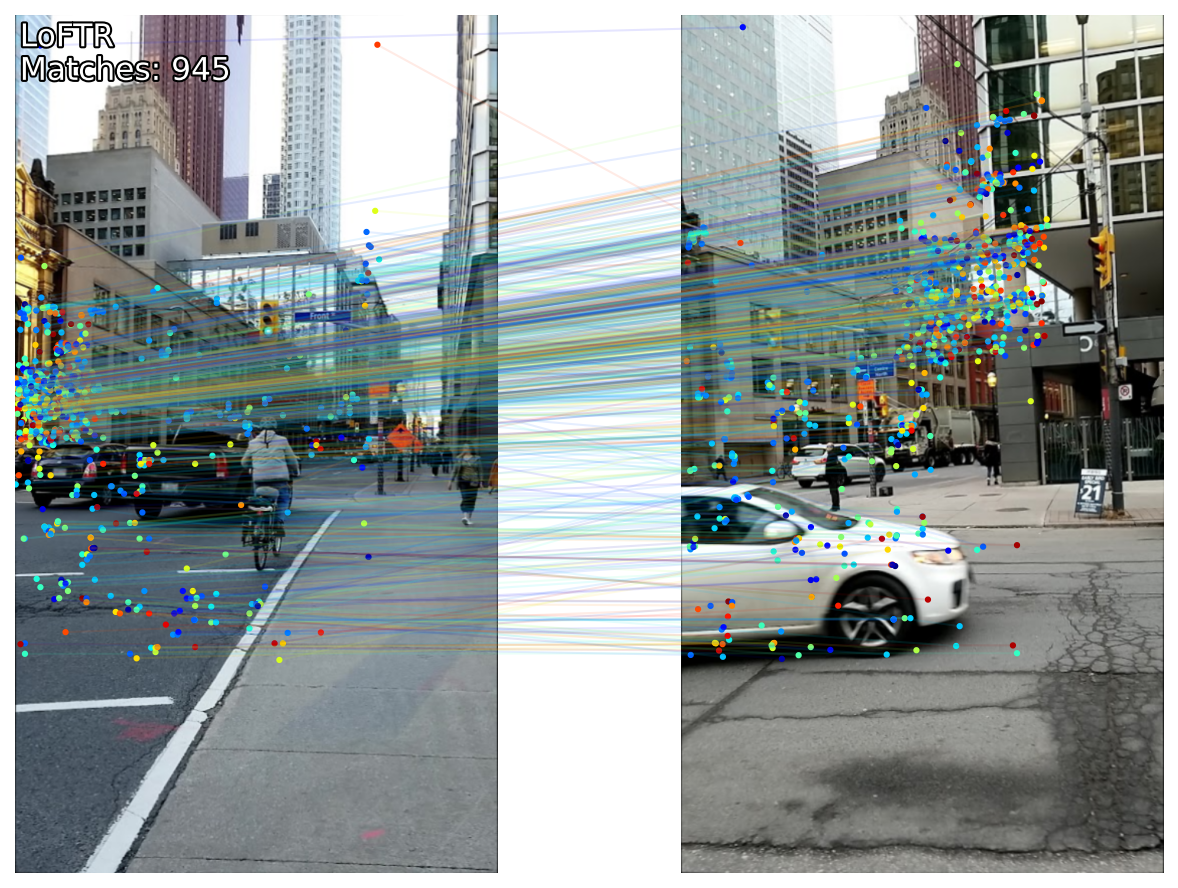

In [ ]:
# Draw matches for a single pair from the results
import matplotlib.cm as cm
index = 0 # select image pair from results DataFrame
threshold = 0 # setting a confidence threshold between 0 and 1 (0 will plot all matches)

# img0_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[0] + '.jpg'))
# img1_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[1] + '.jpg'))
img0 = load_image("/content/drive/MyDrive/dkm-dependecies/img5.png")
img1 = load_image("/content/drive/MyDrive/dkm-dependecies/img6.png")
df_draw = pd.DataFrame({'mkpts0': mkpts0.tolist(), 'mkpts1': mkpts1.tolist(), 'mconf': confi})
color = cm.jet(df_draw.query(f'mconf > {threshold}').mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(df_draw.query(f'mconf > {threshold}')))]
fig = make_matching_figure(img0, img1, np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), 
                                    np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), color, text=text, dpi=150, alpha = 0.1, lines = True)
fig